# Intial commands

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline

In [2]:
patients = pd.read_csv("patients.csv")
controls = pd.read_csv("controls.csv")

In [3]:
df = pd.concat([patients, controls])
df.head()

,PATIENT,SN_DX,INDEX_DX,SN_SIN,INDEX_SIN,3rd_ventricle
0,1,0.11,25.68,0.09,36.28,7.6
1,1,0.06,25.15,0.09,32.65,5.7
2,1,0.09,25.57,0.21,33.91,6.4
3,1,0.26,27.43,0.32,29.05,6.8
4,1,0.05,25.32,0.06,22.81,4.2


# Plotting data

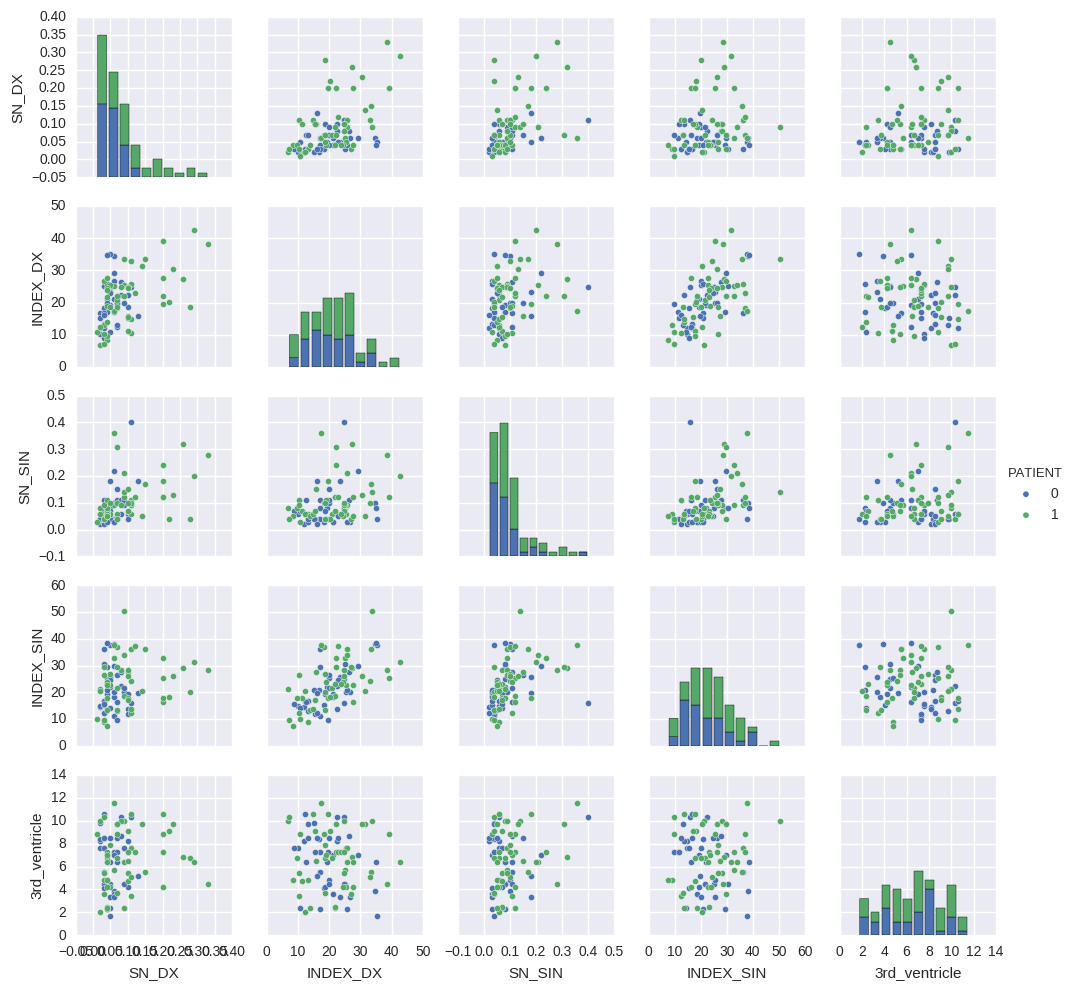

In [12]:
sns.pairplot(df.dropna(how='any'), vars=[x for x in df.columns if x!='PATIENT'], hue="PATIENT", size=2)

# Correlations

## Whole sample correlation

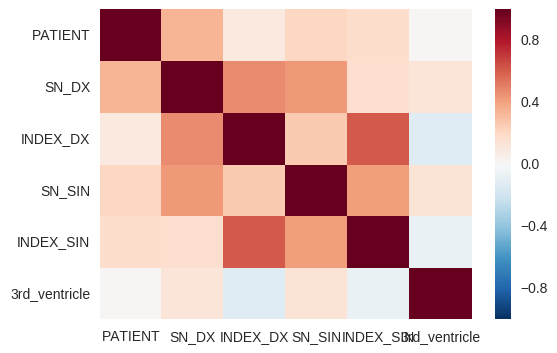

In [13]:
sns.heatmap(df.corr())

## Patients correlations

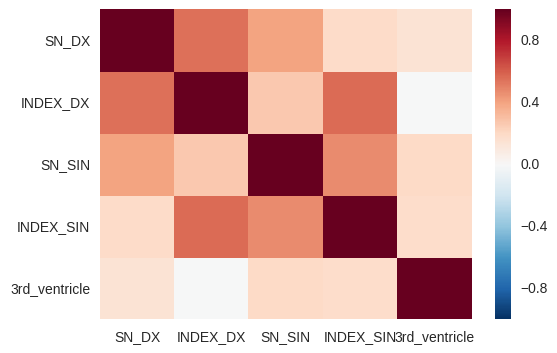

In [21]:
sns.heatmap(df.loc[df['PATIENT'] == 1].drop(['PATIENT'], axis=1).corr())

## Controls correlations

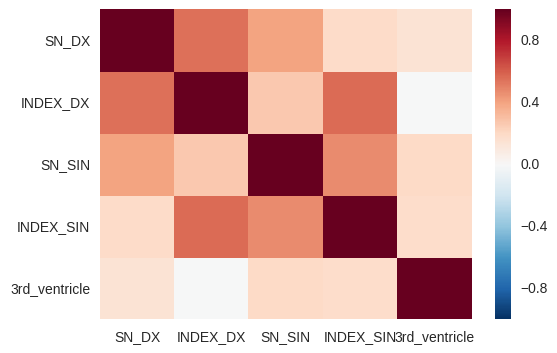

In [22]:
sns.heatmap(df.loc[df['PATIENT'] == 1].drop(['PATIENT'], axis=1).corr())

# Group comparisons

## Plots

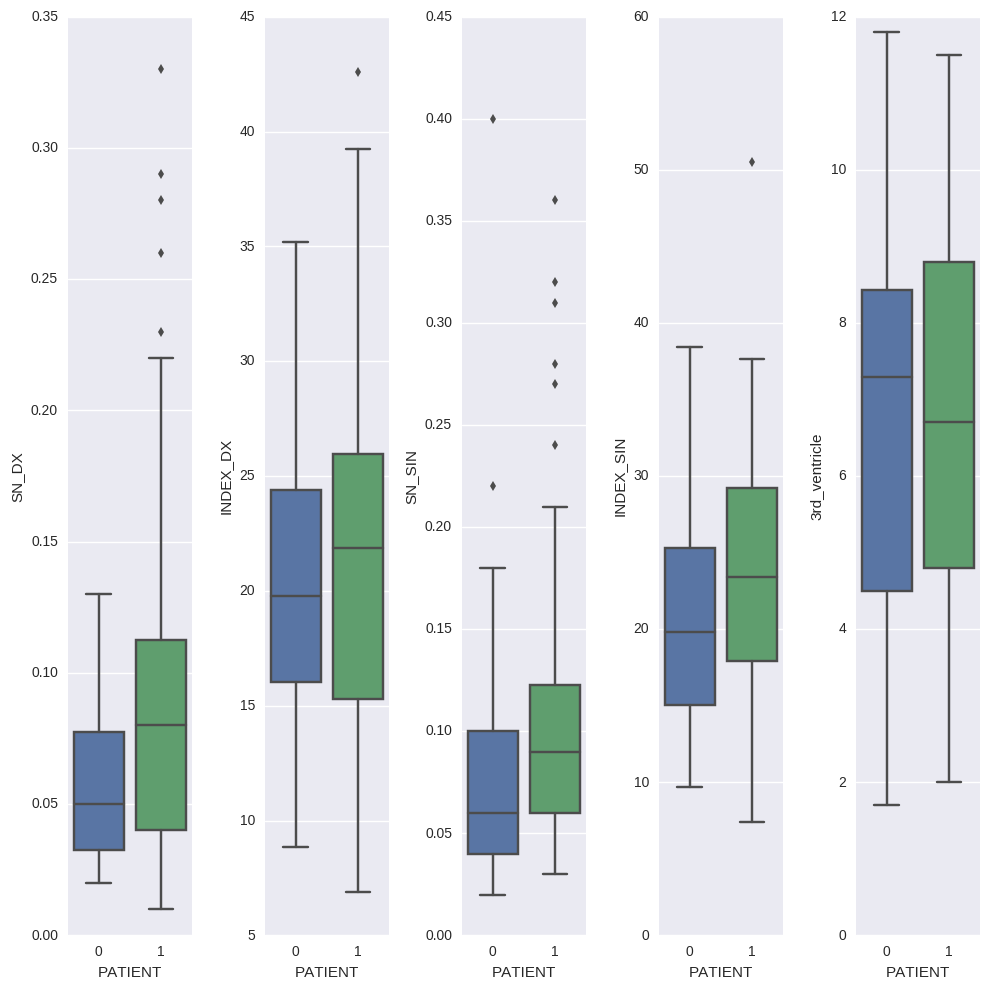

In [72]:
f, axes = plt.subplots(1, len(df.columns)-1, figsize=(10, 10), sharex=True)
i = 0
for column in df.columns:
    if column != "PATIENT":
        sns.boxplot(x="PATIENT", y=column, data=df, ax=axes[i])
        i = i + 1
#plt.setp(axes, yticks=[])
plt.tight_layout()

## Parametric testing prerequisities

Shapiro: Shapiro-Wilk's test for normality.

Levene: Levene's test for homoscedasticity.

In [46]:
prereq = {}
prereq_p = {}
for column in df.columns:
    if column != 'PATIENT':
        prereq_p[column] = []
        prereq[column] = []
        
        #All Normality Shapiro-Wilk test
        W, p = scipy.stats.shapiro(df[column].dropna())
        normality = p > 0.05
        prereq_p[column].append(p)
        prereq[column].append(normality)
        
        #Patients Normality Shapiro-Wilk test
        W, p = scipy.stats.shapiro(df.loc[df['PATIENT'] == 1, column].dropna())
        normality = p > 0.05
        prereq_p[column].append(p)
        prereq[column].append(normality)

        #Controls Normality Shapiro-Wilk test
        W, p = scipy.stats.shapiro(df.loc[df['PATIENT'] == 0, column].dropna())
        normality = p > 0.05
        prereq_p[column].append(p)
        prereq[column].append(normality)

        #Patients & Controls Homoscedasticity
        W, p = scipy.stats.levene(df.loc[df['PATIENT'] == 1, column].dropna(), df.loc[df['PATIENT'] == 0, column].dropna())
        homoscedasticity = p > 0.05
        prereq_p[column].append(p)
        prereq[column].append(homoscedasticity)
        
prerequisities = pd.DataFrame(prereq, index=['all_normality', 'patients_normality', 'controls_normality', 'homoscedasticity'])
prerequisities_p = pd.DataFrame(prereq_p, index=['all_Shapiro', 'patients_Shapiro', 'controls_Shapiro', 'Levene'])

In [47]:
prerequisities

,3rd_ventricle,INDEX_DX,INDEX_SIN,SN_DX,SN_SIN
all_normality,True,True,False,False,False
patients_normality,True,True,True,False,False
controls_normality,True,True,False,False,False
homoscedasticity,True,True,True,False,True


In [48]:
prerequisities_p

,3rd_ventricle,INDEX_DX,INDEX_SIN,SN_DX,SN_SIN
all_Shapiro,0.092313,0.078356,0.022616,3.127079e-10,1.780972e-10
patients_Shapiro,0.150420,0.343877,0.555089,1.236638e-05,1.623039e-06
controls_Shapiro,0.173592,0.171754,0.008342,2.676337e-02,6.168736e-08
Levene,0.796353,0.057871,0.362403,3.651928e-04,2.425329e-01


## Stastistical tests

In [78]:
test = {}
for column in df.columns:
    if column != 'PATIENT':
        test[column] = []
        
        homoscedasticity = prerequisities.loc['homoscedasticity'][column]
        
        #Student's T-test
        if homoscedasticity:
            t, p = scipy.stats.ttest_ind(
                df.loc[df['PATIENT'] == 1, column].dropna(),
                df.loc[df['PATIENT'] == 0, column].dropna(),
                equal_var=homoscedasticity
            )
            test[column].append(p) #Student's T-test (prerequisities fullfilled)
            test[column].append('') #Welsh T-test
        
        #Welsh T-test
        else:
            t, p = scipy.stats.ttest_ind(
                df.loc[df['PATIENT'] == 1, column].dropna(),
                df.loc[df['PATIENT'] == 0, column].dropna(),
                equal_var=homoscedasticity
            )
            test[column].append('') #Student's T-test (prerequisities not fullfilled)
            test[column].append(p)
        
        #Mann-Whitney U-test
        u, p = scipy.stats.mannwhitneyu(
                df.loc[df['PATIENT'] == 1, column].dropna(),
                df.loc[df['PATIENT'] == 0, column].dropna()
        )
        test[column].append(p)

test = pd.DataFrame(test, index=['Student_T-test', 'Welsh_T-test', 'Mann-Whitney_U-test'])

In [79]:
test

,3rd_ventricle,INDEX_DX,INDEX_SIN,SN_DX,SN_SIN
Student_T-test,0.927578,0.33496,0.0662808,,0.034033
Welsh_T-test,,,,0.000405597,
Mann-Whitney_U-test,0.99457,0.385951,0.05596,0.00727194,0.00905439


## Bonferoni correction 

In [80]:
print "p = {}".format( 0.05/float(len(test.columns)) )

p = 0.01
